## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
import os

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
nx = 9
ny = 6

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                [img_size[0]-offset, img_size[1]-offset], 
                                [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
        cv2.imshow('img',warped)
          
        #cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## And so on and so forth...

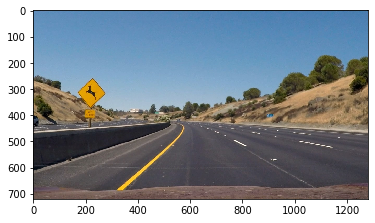

In [2]:
%matplotlib inline
image = mpimg.imread('../test_images/test2.jpg')
plt.imshow(image)
# import os
# images = os.listdir("../test_images/")

In [7]:
def hls_select_S(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H= hls[:,:,0]
    L= hls[:,:,1] 
    S= hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0]) & (S <= thresh[1])] = 1
    #binary_output = np.zeros_like(H)
    #binary_output[(H>thresh[0]) & (H <= thresh[1])] = 1
    
    
    return binary_output

def hls_select_H(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H= hls[:,:,0]
    L= hls[:,:,1] 
    S= hls[:,:,2]
    binary_output = np.zeros_like(H)
    binary_output[(H>thresh[0]) & (H <= thresh[1])] = 1
    
    return binary_output

def hls_select_L(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H= hls[:,:,0]
    L= hls[:,:,1] 
    S= hls[:,:,2]
    binary_output = np.zeros_like(L)
    binary_output[(L>thresh[0]) & (L <= thresh[1])] = 1

def red_select(image, thresh):
    R = image [:,:,0]
    binary = np.zeros_like(R)
    binary[(R>thresh[0]) & (R<= thresh[1])] =1
    
    return binary

def green_select(image, thresh):
    G = image [:,:,1]
    binary = np.zeros_like(G)
    binary[(G>thresh[0]) & (G<= thresh[1])] =1
    
    return binary
    
    
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel , mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1 , 0)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min(mag_thresh)) & (scaled_sobel <= max(mag_thresh))] =1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel, thresh):
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradientsa
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dirGrad = np.arctan2(abs_sobely, abs_sobelx)
    #print('disGrad is' ,type(dirGrad))
    # 5) Create a binary mask wrhere direction thresholds are met
    binary_output = np.zeros_like(dirGrad)
    binary_output[(dirGrad >= min(thresh)) & (dirGrad <= max(thresh))] =1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def warper(img, reverse=False):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

def hist(img):
     # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    #bottom_half = None
    height, width = img.shape[:2]
    
    # Corp_bottom
    start_row, start_col = int(height/2), int(0)
    end_row, end_col = int(height), int(width)
    print(start_row, start_col)
    print(end_row, end_col)
    bottom_half = img[start_row:end_row, start_col:end_col]
    #plt.imshow(bottom_half)
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(img[img.shape[0]//2:,:], axis =0)
    #plt.plot(histogram)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty



def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    print('nonzero :', nonzero)
    nonzeroy = np.array(nonzero[0])
    print('nonzeroy: ', nonzeroy)
    nonzerox = np.array(nonzero[1])
    print('nonzerox', nonzerox)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
#     print('left_lane_inds: ', left_lane_inds)
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
#     print('right_lane_inds: ', right_lane_inds)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
#     print('leftx and lefty :', leftx, lefty)
#     print('rightx and righty:', rightx, righty)
#     print('out_img:', out_img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    #print('ploty ',type(ploty), ploty )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#         print('left_fitx: ', left_fitx)
#         print('right_fitx: ' , right_fitx)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, out_img


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
#     print('leftx_base is', leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#     print('rightx_base is,' , rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
#     print('window_height :', window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
#         print('window: ', window)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
#         print('win_y_low:', win_y_low)
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
         
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         print('good_left_inds:  ', good_left_inds)
#         print('good_right_inds:  ', good_right_inds)
#         print('-----')
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             print('leftx_current: ', leftx_current)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#             print('rightx_current: ', rightx_current)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img


def measure_curvature_pixels(img, ploty, left_fit, right_fit):
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
#     ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    width = img.shape[1]
    height = img.shape[0]
    # Calculate vehicle position with respect to center
    left_lane_pos = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_lane_pos = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    # print("left_lane_pos: " + str(left_lane_pos))
    # print("right_lane_pos: " + str(right_lane_pos))
    
    car_pos = width / 2
    middle_lane_pos = left_lane_pos + (right_lane_pos - left_lane_pos) / 2
    car_offset = (middle_lane_pos - car_pos) * xm_per_pix
    
    return left_curverad, right_curverad, car_offset



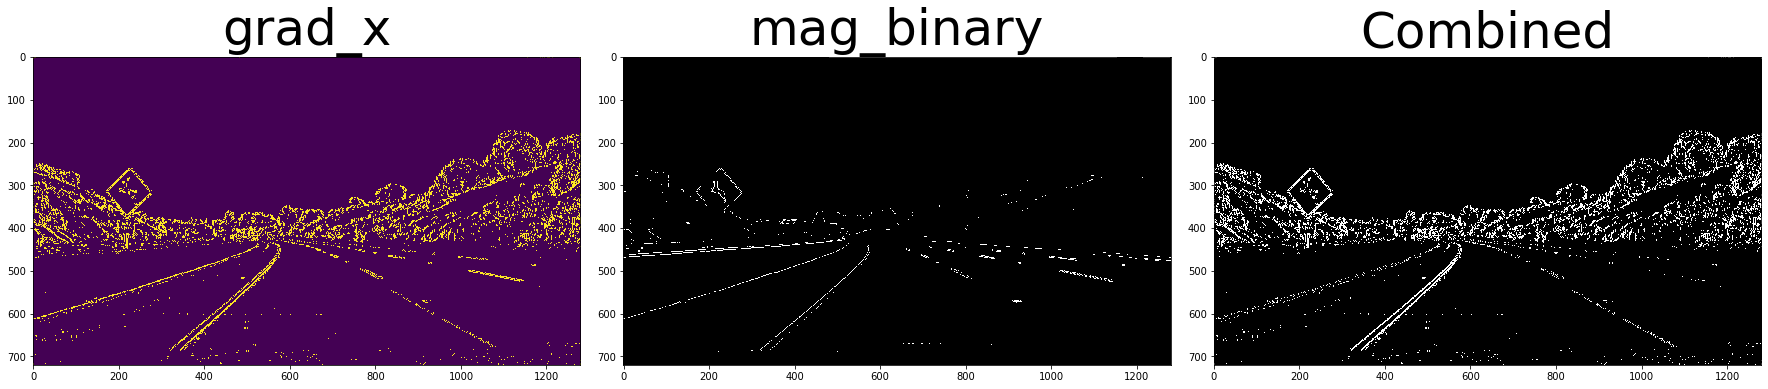

In [4]:
# Gradient
ksize = 3
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 80))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.0))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# plt.imshow(combined, cmap = 'gray')
f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx)
ax1.set_title('grad_x', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('mag_binary', fontsize=50)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

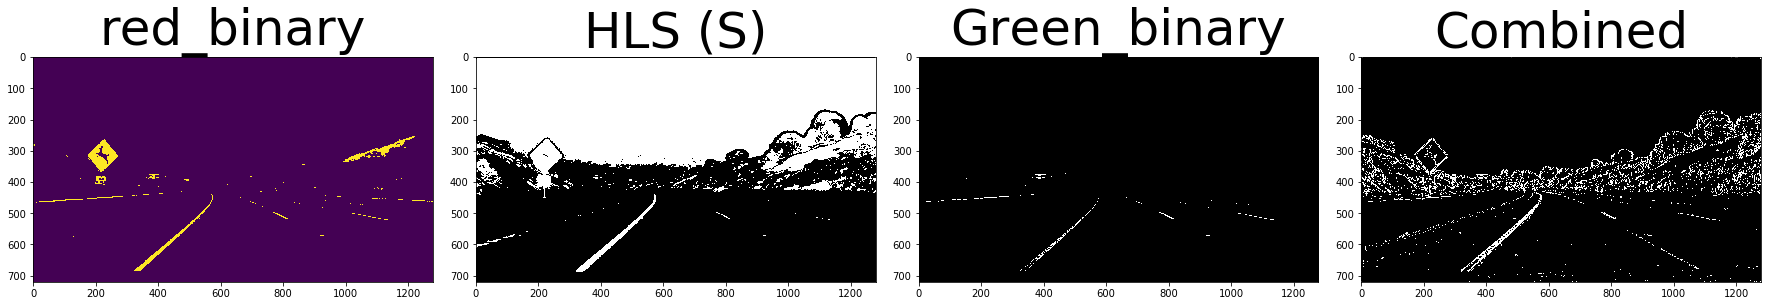

In [8]:
# hls 
red_binary = red_select(image, thresh = (200, 255))
green_binary = green_select(image,thresh=(200,255))
hls_binary_S = hls_select_S(image, thresh= (80, 255))
hls_binary_H = hls_select_H(image, thresh= (0, 10))
# hls_binary_L = hls_select_L(image, thresh = (0,10))

combined = np.zeros_like(hls_binary_H)
combined[((hls_binary_H ==1) & (hls_binary_S ==1))|(red_binary ==1)&(green_binary==1)|((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] =1 

# plt.imshow(combined, cmap = 'gray')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(24, 9))
f.tight_layout()
ax1.imshow(red_binary)
ax1.set_title('red_binary', fontsize=50)
ax2.imshow(hls_binary_S, cmap='gray') 
ax2.set_title('HLS (S)', fontsize=50)
ax3.imshow(green_binary, cmap='gray')
ax3.set_title('Green_binary', fontsize=50)
ax4.imshow(combined, cmap='gray')
ax4.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

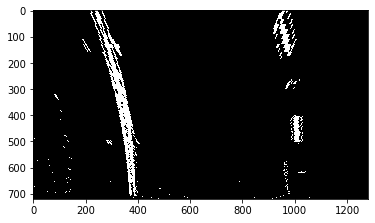

In [9]:
warped, Minv= warper(combined, reverse=False)
plt.imshow(warped, cmap= 'gray')

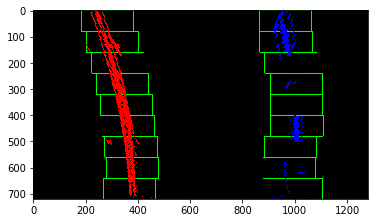

In [10]:
#%matplotlib qt
left_fitx, right_fitx, ploty, left_fit, right_fit, out_img= fit_polynomial(warped)
#print('out_img :', out_img)
plt.imshow(out_img)
# Create an image to draw the lines on



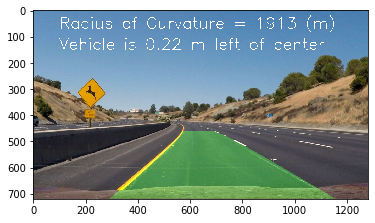

In [11]:
# %matplotlib qt
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))



# print(left_curverad, right_curverad)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

left_curverad, right_curverad , car_offset= measure_curvature_pixels(image, ploty, left_fit, right_fit)
average_curverad = (left_curverad + right_curverad) / 2
    
radius_text = "Radius of Curvature = {:d} (m)".format(int(average_curverad))
cv2.putText(result, radius_text, (100, 70), cv2.FONT_HERSHEY_SIMPLEX, 2,  
            (255, 255, 255), 2 )
    
# print(car_offset)
if car_offset < 0:
    direction = "right"
else:
    direction = "left"
offset_text = "Vehicle is {:.2f} m ".format(car_offset) + direction + " of center"
cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2,  
            (255, 255, 255), 2 )


plt.figure()
plt.imshow(result)



In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [14]:
def process_video(image):
#     gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 180))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 60))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     hls_binary = hls_select_S(image, thresh = (150, 255))
   
    hls_binary_S = hls_select_S(image, thresh= (80, 255))
    hls_binary_H = hls_select_H(image, thresh= (5, 20))
    red_binary = red_select(image, thresh = (200, 255))
    green_binary = green_select(image,thresh=(200,255))

    combined = np.zeros_like(hls_binary_H)
    combined[((hls_binary_H ==1) & (hls_binary_S ==1))|((red_binary ==1) &(green_binary ==1))] =1 


    img_size = (image.shape[1], image.shape[0])

    warped , Minv = warper(combined, reverse=False)
    left_fitx, right_fitx, ploty, left_fit, right_fit, out_img = fit_polynomial(warped)
    
    
    # Create an image to draw the lines on
   
    color_warp = np.dstack((warped, warped, warped))*255
    warp_zero = np.zeros_like(color_warp).astype(np.uint8)
    
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
#     print('----')
#     plt.imshow(newwarp)

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
#     unwarped = warper(color_warp, reverse=True)
#     result = cv2.addWeighted(unwarped, 0.5, warped, 1, 0)
    left_curverad, right_curverad , car_offset= measure_curvature_pixels(warped, ploty, left_fit, right_fit)
    average_curverad = (left_curverad + right_curverad) / 2
    
    radius_text = "Radius of Curvature = {:d} (m)".format(int(average_curverad))
    cv2.putText(result, radius_text, (100, 70), cv2.FONT_HERSHEY_SIMPLEX, 2,  
            (255, 255, 255), 2 )
    
# print(car_offset)
    if car_offset < 0:
        direction = "right"
    else:
        direction = "left"
    offset_text = "Vehicle is {:.2f} m ".format(car_offset) + direction + " of center"
    cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2,  
                (255, 255, 255), 2 )

    return result

directory = "../output_video"
if not os.path.exists(directory):
    os.mkdir(directory)

In [15]:
#plt.imshow(process_image)
output1 = '../output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the 
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output1, audio=False)

t:   0%|          | 2/1260 [00:00<01:14, 16.88it/s, now=None]

Moviepy - Building video ../output_video/project_video.mp4.
Moviepy - Writing video ../output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready ../output_video/project_video.mp4
CPU times: user 4min 22s, sys: 46.3 s, total: 5min 9s
Wall time: 2min 3s


In [16]:
HTML("""|
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))